## **Presented By:** 
### - Azzouzi Ousssama Abderraouf
### - Mohamed Saadi

# ===============================================================

# 1- Imports

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance


# 2- loading datasets

In [61]:
data_path = '011/text_data/'

ada_joy = data_path + 'ada_joy.csv'
assistance_info = data_path + 'assistance_info.csv'
gaze_positions = data_path + 'gaze_positions.csv'
input_info = data_path + 'input_info.csv'
joint_positions = data_path + 'joint_positions.csv'
myo_emg = data_path + 'myo_emg.csv'
myo_imu = data_path + 'myo_imu.csv'
myo_ori = data_path + 'myo_ori.csv'
pupil_cal_eye0 = data_path + 'pupil_cal_eye0.csv'
pupil_cal_eye1 = data_path + 'pupil_cal_eye1.csv'
pupil_eye0 = data_path + 'pupil_eye0.csv'
pupil_eye1 = data_path + 'pupil_eye1.csv'
robot_position = data_path + 'robot_position.csv'
world_cal_positions = data_path + 'world_cal_positions.csv'

ada_joy_df = pd.read_csv(ada_joy)
assistance_info_df = pd.read_csv(assistance_info)
gaze_positions_df = pd.read_csv(gaze_positions)
input_info_df = pd.read_csv(input_info)
joint_positions_df = pd.read_csv(joint_positions)
myo_emg_df = pd.read_csv(myo_emg)
myo_imu_df = pd.read_csv(myo_imu)
myo_ori_df = pd.read_csv(myo_ori)
pupil_cal_eye0_df = pd.read_csv(pupil_cal_eye0)
pupil_cal_eye1_df = pd.read_csv(pupil_cal_eye1)
pupil_eye0_df = pd.read_csv(pupil_eye0)
pupil_eye1_df = pd.read_csv(pupil_eye1)
robot_position_df = pd.read_csv(robot_position)
world_cal_positions_df = pd.read_csv(world_cal_positions)

# ada_joy_df.head(), assistance_info_df.head(), gaze_positions_df.head(), input_info_df.head(), joint_positions_df.head(), myo_emg_df.head(), myo_imu_df.head(), myo_ori_df.head(), pupil_cal_eye0_df.head(), pupil_cal_eye1_df.head(), pupil_eye0_df.head(), pupil_eye1_df.head(), robot_position_df.head(), world_cal_positions_df.head()



# 3- Data Preprocessing

In [62]:
# # print the column names of the dataframes
# print('ada_joy_df columns: ', ada_joy_df.columns)
# print('assistance_info_df columns: ', assistance_info_df.columns)
# print('gaze_positions_df columns: ', gaze_positions_df.columns)
# print('input_info_df columns: ', input_info_df.columns)
# print('joint_positions_df columns: ', joint_positions_df.columns)
# print('myo_emg_df columns: ', myo_emg_df.columns)
# print('myo_imu_df columns: ', myo_imu_df.columns)
# print('myo_ori_df columns: ', myo_ori_df.columns)
# print('pupil_cal_eye0_df columns: ', pupil_cal_eye0_df.columns)
# print('pupil_cal_eye1_df columns: ', pupil_cal_eye1_df.columns)
# print('pupil_eye0_df columns: ', pupil_eye0_df.columns)
# print('pupil_eye1_df columns: ', pupil_eye1_df.columns)
# print('robot_position_df columns: ', robot_position_df.columns)
# print('world_cal_positions_df columns: ', world_cal_positions_df.columns)


In [63]:
# Combine datasets based on timestamp (outer join to keep all timestamps)
combined_df = pd.merge(ada_joy_df, gaze_positions_df, on='timestamp', how='outer')
combined_df = pd.merge(combined_df, myo_emg_df, on='timestamp', how='outer')

# Handling missing values (example: fill with mean)
for col in combined_df.columns:
    try:
        combined_df[col] = combined_df[col].astype(float)
    except ValueError:
        print(f"Could not convert column {col} to float")

combined_df = combined_df.fillna(combined_df.select_dtypes(include=[np.number]).mean())
combined_df = combined_df.fillna(0)
combined_df = combined_df.drop(columns=['base_data'])

#  calculate the mean of each numeric column and convert to double
# mean = combined_df.select_dtypes(include=[np.number]).mean()
mean = combined_df.mean()

mean = mean.astype(float)

# print(mean)  # use dtype instead of type()

# Check for missing values
# print(combined_df.isnull().sum())

# combined_df.head(), 
print(combined_df.columns)

Could not convert column base_data to float
Index(['timestamp', 'world_index_x', 'world_index_corrected_x', 'axes_x',
       'axes_y', 'axes_z', 'buttons_0', 'buttons_1', 'world_index_y',
       'world_index_corrected_y', 'confidence', 'norm_pos_x', 'norm_pos_y',
       'gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z',
       'eye_center0_3d_x', 'eye_center0_3d_y', 'eye_center0_3d_z',
       'gaze_normal0_x', 'gaze_normal0_y', 'gaze_normal0_z',
       'eye_center1_3d_x', 'eye_center1_3d_y', 'eye_center1_3d_z',
       'gaze_normal1_x', 'gaze_normal1_y', 'gaze_normal1_z', 'world_index',
       'world_index_corrected', 'emg0', 'emg1', 'emg2', 'emg3', 'emg4', 'emg5',
       'emg6', 'emg7', 'moving'],
      dtype='object')


In [64]:
moving_df = combined_df.loc[combined_df['moving'] != 0]
moving_df.head()

,timestamp,world_index_x,world_index_corrected_x,axes_x,axes_y,axes_z,buttons_0,buttons_1,world_index_y,world_index_corrected_y,...,world_index_corrected,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7,moving


# 4- Feature Selection

In [65]:
# Assuming 'moving' is your target variable, you can adjust it accordingly
target_variable = ('gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z')

# Identify redundant features and drop them (you may customize this based on your data)
redundant_features = ['world_index_x', 'world_index_corrected_x', 'world_index_y', 'world_index_corrected_y']
redundant_features = [col for col in redundant_features if col in combined_df.columns]  # Check if columns exist
combined_df = combined_df.drop(columns=redundant_features)

# Select features and target variable
features = combined_df.drop(columns=list(target_variable) + ['timestamp'])
target = combined_df[list(target_variable)]

# Check for highly correlated features and drop if necessary
correlation_matrix = features.corr()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
features = features.drop(columns=to_drop)

# Confirm the selected features and target variable
print("Selected Features:", features.columns)
print("Target Variable:", target_variable)

Selected Features: Index(['axes_x', 'axes_y', 'axes_z', 'buttons_0', 'buttons_1', 'confidence',
       'norm_pos_x', 'norm_pos_y', 'eye_center0_3d_x', 'eye_center0_3d_z',
       'gaze_normal0_y', 'gaze_normal0_z', 'eye_center1_3d_x',
       'eye_center1_3d_y', 'gaze_normal1_x', 'gaze_normal1_y',
       'gaze_normal1_z', 'world_index', 'emg0', 'emg1', 'emg2', 'emg3', 'emg4',
       'emg5', 'emg6', 'emg7', 'moving'],
      dtype='object')
Target Variable: ('gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z')


# 5- Data Splitting

In [66]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Confirm the shapes of the sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training set shape:", y_train.shape)
print("Testing set shape:", y_test.shape)
features

Training set shape: (19312, 27)
Testing set shape: (4829, 27)
Training set shape: (19312, 3)
Testing set shape: (4829, 3)


,axes_x,axes_y,axes_z,buttons_0,buttons_1,confidence,norm_pos_x,norm_pos_y,eye_center0_3d_x,eye_center0_3d_z,...,world_index,emg0,emg1,emg2,emg3,emg4,emg5,emg6,emg7,moving
0,-0.00,-0.00,-0.00,0.00,0.00,0.96,0.49,0.56,19.89,-20.93,...,1248.53,112.49,236.61,349.20,227.34,156.19,108.91,81.95,91.18,0.00
1,-0.00,-0.00,-0.00,0.00,0.00,0.96,0.49,0.56,19.89,-20.93,...,1248.53,112.49,236.61,349.20,227.34,156.19,108.91,81.95,91.18,0.00
2,-0.00,-0.00,-0.00,0.00,0.00,0.96,0.49,0.56,19.89,-20.93,...,1248.53,112.49,236.61,349.20,227.34,156.19,108.91,81.95,91.18,0.00
3,0.00,-0.00,-0.00,0.00,0.00,0.96,0.49,0.56,19.89,-20.93,...,1248.53,112.49,236.61,349.20,227.34,156.19,108.91,81.95,91.18,0.00
4,0.03,-0.00,-0.00,0.00,0.00,0.96,0.49,0.56,19.89,-20.93,...,1248.53,112.49,236.61,349.20,227.34,156.19,108.91,81.95,91.18,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24136,0.08,0.04,0.01,0.02,0.00,0.96,0.49,0.56,19.89,-20.93,...,2495.00,42.00,144.00,230.00,110.00,50.00,46.00,40.00,31.00,0.00
24137,0.08,0.04,0.01,0.02,0.00,0.96,0.49,0.56,19.89,-20.93,...,2496.00,48.00,142.00,249.00,116.00,47.00,46.00,39.00,33.00,0.00
24138,0.08,0.04,0.01,0.02,0.00,0.96,0.49,0.56,19.89,-20.93,...,2496.00,47.00,132.00,246.00,119.00,50.00,46.00,39.00,33.00,0.00
24139,0.08,0.04,0.01,0.02,0.00,0.96,0.49,0.56,19.89,-20.93,...,2497.00,44.00,133.00,229.00,113.00,48.00,45.00,38.00,31.00,0.00


In [67]:
ada_joy_df.head()

,timestamp,world_index,world_index_corrected,axes_x,axes_y,axes_z,buttons_0,buttons_1
0,5.24,147,156,-0.00,-0.00,-0.00,0,0
1,5.25,147,156,-0.00,-0.00,-0.00,0,0
2,5.26,148,157,-0.00,-0.00,-0.00,0,0
3,5.27,148,157,0.00,-0.00,-0.00,0,0
4,5.28,148,157,0.03,-0.00,-0.00,0,0


# 6- Model Selection and Training

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# # Initialize the model
# model = RandomForestRegressor(random_state=42)

# # Train the model
# model.fit(X_train, y_train)

# # Predict on the training set
# train_predictions = model.predict(X_train)

# # Predict on the testing set
# test_predictions = model.predict(X_test)

# # Evaluate the model
# train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
# test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

# print("Training RMSE:", train_rmse)
# print("Testing RMSE:", test_rmse)

In [69]:
# creating a grid search for the RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Defining the hyperparameters and their values
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
print(best_model)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor(min_samples_leaf=2, n_estimators=200, random_state=42)


Training RMSE: 3.240902217225743
Testing RMSE: 1.9481518798336301
Training MSE: 14.21836480802842
Testing MSE: 6.457698441756946


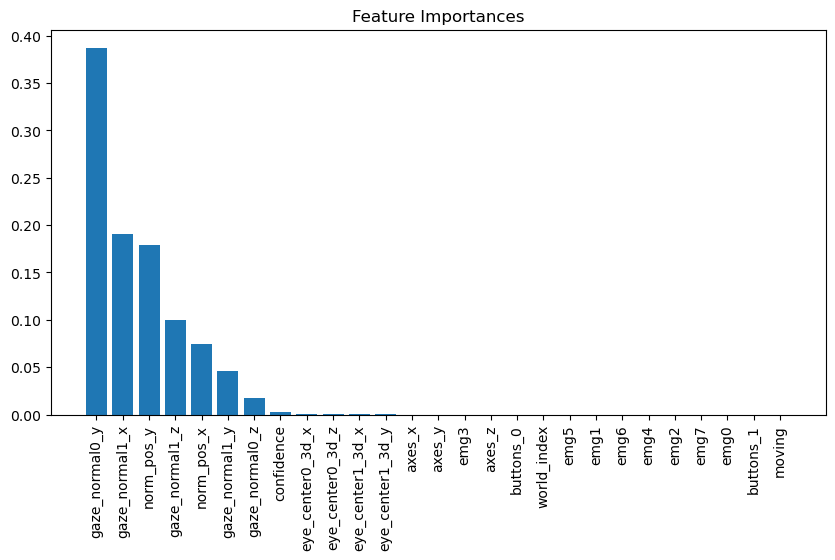

In [70]:
import math

# Train the model
best_model.fit(X_train, y_train)

# Predict on the training set
train_predictions = best_model.predict(X_train)

# Predict on the testing set
test_predictions = best_model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

# Ploting the feature importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns
plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()


Model Accuracy: 0.9840566370158962


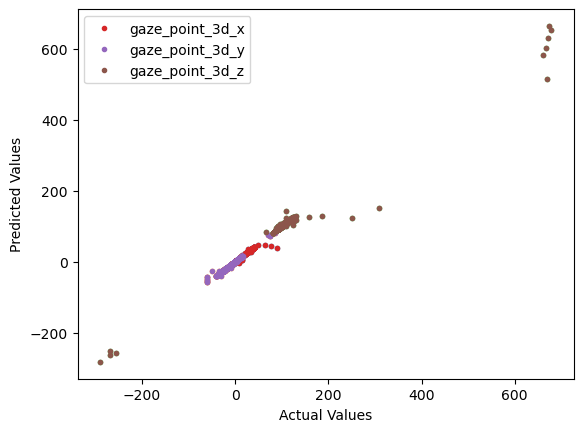

((4829, 3), (4829, 3))

In [71]:
# get the accuracy of the model
accuracy = best_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

# testing the model

# # Ploting the actual values vs the predicted values
plt.plot(y_test.to_numpy(), test_predictions, linestyle='none', marker='.')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# We have 3 target variables, so we will plot the actual vs predicted values for each and mention their labels
plt.plot(y_test.iloc[:, 0], test_predictions[:, 0], linestyle='none', marker='.', label='gaze_point_3d_x')
plt.plot(y_test.iloc[:, 1], test_predictions[:, 1], linestyle='none', marker='.', label='gaze_point_3d_y')
plt.plot(y_test.iloc[:, 2], test_predictions[:, 2], linestyle='none', marker='.', label='gaze_point_3d_z')
plt.legend()

plt.show()

y_test.shape, test_predictions.shape

In [72]:
# plot